https://github.com/jw-code/SentAnalysisLab/blob/main/lab5_sentiment_analysis.ipynb

**برای پیش پردازش دادگان از لینک بالا استفاده شده است.**

amin fathi
400722102


# **Data**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv')
data.head(5)

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,Unnamed: 2
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


In [3]:
# Step 2: Add variable names becuase raw data was missing variable names.
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv' , names=["Customer_Comment", "Sentiment_Classifier", "Flag"])
data.head(2)  

,Customer_Comment,Sentiment_Classifier,Flag
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN


In [4]:
data.groupby("Flag")["Flag"].count()

Flag
------              1
-------             1
----------          1
----------------    1
9090                1
till here           2
Name: Flag, dtype: int64

In [5]:
## Removed Flag field, looks like it is an extraneous variable as per the business objective.
data1 = data[["Customer_Comment", "Sentiment_Classifier"]]
data1.head(2)

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive


In [6]:
#Examine Sentiment Classifier field
data1.groupby("Sentiment_Classifier")["Sentiment_Classifier"].count()

Sentiment_Classifier
Neative        1
Negative    5286
Neutral     8929
Positive    6013
Name: Sentiment_Classifier, dtype: int64

In [7]:
#Clean 'Neative' value from above to 'Negative'
data1['Sentiment_Classifier'] = data1['Sentiment_Classifier'].replace('Neative', 'Negative')
data1.head(2)

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive


In [8]:
# Validate Data
data1.groupby("Sentiment_Classifier")["Sentiment_Classifier"].count()

Sentiment_Classifier
Negative    5287
Neutral     8929
Positive    6013
Name: Sentiment_Classifier, dtype: int64

In [9]:
# Change from 3 classes to 2 by assigning 1 to Negative values and 0 to positive and neutral values
data1["Sentiment_Classifier"] = data1["Sentiment_Classifier"].map({'Negative': 2, 'Positive': 1, 'Neutral':0})

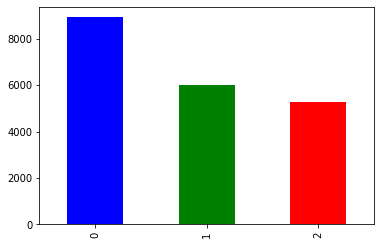

In [10]:
# Visualize Data
data1['Sentiment_Classifier'].value_counts().plot(kind='bar' ,color=['blue', 'green', 'red'])

In [11]:
# Confirm if there is missing Data
print(data1.isnull().sum())

Customer_Comment        1
Sentiment_Classifier    0
dtype: int64


In [12]:
##This shows that there is at least one within Customer_Comment field, so let remove them.
data2 = data1[pd.notnull(data1["Customer_Comment"])]
data1.head()

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1
2,"Kya bt hai,",1
3,Wah je wah,1
4,Are wha kaya bat hai,1


In [13]:
# Confirm if there is missing Data
print(data2.isnull().sum())

Customer_Comment        0
Sentiment_Classifier    0
dtype: int64


In [14]:
# Convert data to lower case, trim leading and trailing white spaces.
# lower case
data2['Customer_Comment'] = data2['Customer_Comment'].str.lower()
data2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [15]:
#trim leading and trailing white spaces
data2 = data2.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [17]:
# Convert Sentiment_Classifier values to integers
data2['Sentiment_Classifier'] = data2.Sentiment_Classifier.astype('category').cat.codes
data2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [18]:
# For a deep learning model we need to know what the input sequence length for our model should be
# Calculate the number of words in the Customer_Comment column and find the maximum value to be used for input sequence

data2['num_words'] = data2.Customer_Comment.apply(lambda x : len(x.split()))

data2['num_words'].max()

301

In [19]:
# Set number of classes and target variable
num_class = len(np.unique(data2.Sentiment_Classifier.values))
y = data2['Sentiment_Classifier'].values
print(num_class)

3


In [20]:
#Tokenize the input and pad
maxlen = 302
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data2.Customer_Comment.values)
post_seq = tokenizer.texts_to_sequences(data2.Customer_Comment.values)
post_seq_padded = pad_sequences(post_seq, maxlen=maxlen)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

33269


In [22]:
# Creating a train test split with 30% in testing data set
x_train, x_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.30)

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

# **SimpleRNN**

In [25]:
# Build Model
model1 = keras.Sequential()
# Add an Embedding layer
# output embedding dimension of size 256.
model1.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen)).
model1.add(layers.SimpleRNN(256))
# Add a Dense layer with  units.
model1.add(layers.Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 302, 32)           1064608   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               73984     
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 1,139,363
Trainable params: 1,139,363
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)
loss, metric = model1.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Epoch 1/10
222/222 [==============================] - 79s 356ms/step - loss: 1.0801 - accuracy: 0.4144 - val_loss: 1.0501 - val_accuracy: 0.4655
Epoch 2/10
222/222 [==============================] - 79s 354ms/step - loss: 1.0031 - accuracy: 0.5053 - val_loss: 1.0542 - val_accuracy: 0.3996
Epoch 3/10
222/222 [==============================] - 78s 351ms/step - loss: 0.8996 - accuracy: 0.5983 - val_loss: 1.0219 - val_accuracy: 0.4902
Epoch 4/10
222/222 [==============================] - 77s 348ms/step - loss: 0.6703 - accuracy: 0.7252 - val_loss: 1.0399 - val_accuracy: 0.5306
Epoch 5/10
222/222 [==============================] - 78s 350ms/step - loss: 0.4356 - accuracy: 0.8334 - val_loss: 1.1606 - val_accuracy: 0.5200
Epoch 6/10
222/222 [==============================] - 82s 367ms/step - loss: 0.2693 - accuracy: 0.9070 - val_loss: 1.3589 - val_accuracy: 0.5332
Epoch 7/10
222/222 [==============================] - 92s 417ms/step - loss: 0.1779 - accuracy: 0.9404 - val_loss: 1.5719 - val_ac

In [30]:
loss, metric = model1.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.517


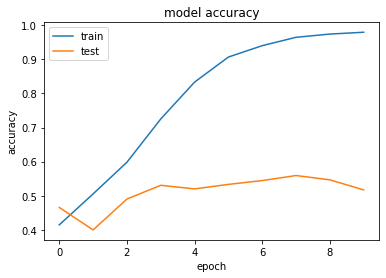

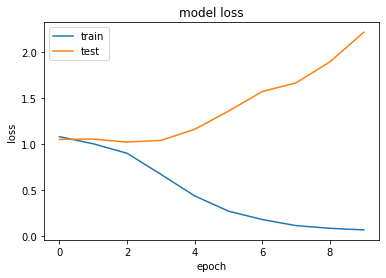

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **SimpleRNN + Dropout**

In [42]:
# Build Model
model2 = keras.Sequential()
# Add an Embedding layer
# output embedding dimension of size 256.
model2.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen))
model2.add(layers.SimpleRNN(256 , return_sequences = True))
model2.add(layers.Dropout(0.3))
model2.add(layers.SimpleRNN(128  , return_sequences = True))
model2.add(layers.Dropout(0.3))
model2.add(layers.SimpleRNN(64))
# Add a Dense layer with 3 units.
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 302, 32)           1064608   
                                                                 
 simple_rnn (SimpleRNN)      (None, 302, 256)          73984     
                                                                 
 dropout_6 (Dropout)         (None, 302, 256)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 302, 128)          49280     
                                                                 
 dropout_7 (Dropout)         (None, 302, 128)          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_4 (Dense)             (None, 3)                

In [43]:
# Compile model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
history = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 222s 994ms/step - loss: 1.0817 - accuracy: 0.4337 - val_loss: 1.0782 - val_accuracy: 0.4325
Epoch 2/5
222/222 [==============================] - 219s 988ms/step - loss: 1.0747 - accuracy: 0.4455 - val_loss: 1.0801 - val_accuracy: 0.4325
Epoch 3/5
222/222 [==============================] - 219s 987ms/step - loss: 1.0722 - accuracy: 0.4451 - val_loss: 1.0771 - val_accuracy: 0.4325
Epoch 4/5
222/222 [==============================] - 218s 983ms/step - loss: 1.0728 - accuracy: 0.4446 - val_loss: 1.0774 - val_accuracy: 0.4325
Epoch 5/5
222/222 [==============================] - 220s 990ms/step - loss: 1.0733 - accuracy: 0.4447 - val_loss: 1.0814 - val_accuracy: 0.4325


In [46]:
loss, metric = model2.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.433


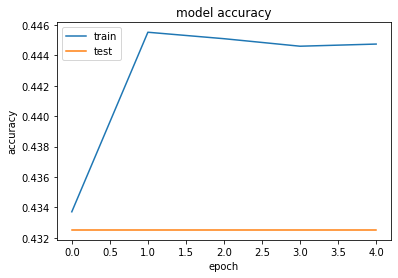

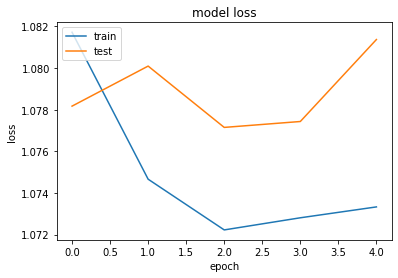

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **LSTM**

In [55]:
model3 = keras.Sequential()
model3.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen))
model3.add(layers.LSTM(256))
model3.add(layers.Dense(3, activation='softmax'))
print(model3.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,361,315
Trainable params: 1,361,315
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
history = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
222/222 [==============================] - 348s 2s/step - loss: 0.9805 - accuracy: 0.5176 - val_loss: 0.8644 - val_accuracy: 0.6083
Epoch 2/10
222/222 [==============================] - 347s 2s/step - loss: 0.6456 - accuracy: 0.7376 - val_loss: 0.8134 - val_accuracy: 0.6492
Epoch 3/10
222/222 [==============================] - 338s 2s/step - loss: 0.3473 - accuracy: 0.8755 - val_loss: 0.9887 - val_accuracy: 0.6339
Epoch 4/10
222/222 [==============================] - 338s 2s/step - loss: 0.1824 - accuracy: 0.9369 - val_loss: 1.1239 - val_accuracy: 0.6332
Epoch 5/10
222/222 [==============================] - 342s 2s/step - loss: 0.1102 - accuracy: 0.9647 - val_loss: 1.5505 - val_accuracy: 0.6284
Epoch 6/10
222/222 [==============================] - 344s 2s/step - loss: 0.0726 - accuracy: 0.9770 - val_loss: 1.7400 - val_accuracy: 0.6169
Epoch 7/10
222/222 [==============================] - 342s 2s/step - loss: 0.1389 - accuracy: 0.9590 - val_loss: 1.5645 - val_accuracy: 0.6309

In [58]:
loss, metric = model3.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.612


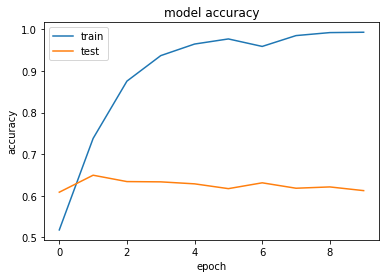

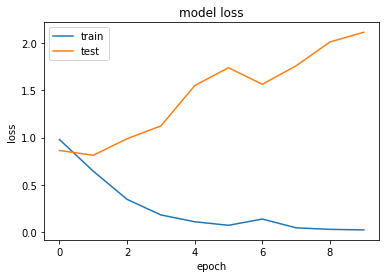

In [59]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **LSTM + Dropout**

In [24]:

model4 = keras.Sequential() 
model4.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen))
model4.add(layers.LSTM(256,return_sequences=True))
model4.add(layers.Dropout(0.2))
model4.add(layers.LSTM(128,return_sequences=True))
model4.add(layers.Dropout(0.2))
model4.add(layers.LSTM(64))
model4.add(layers.Dense(3, activation='softmax'))
print(model4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 302, 32)           1064608   
                                                                 
 lstm (LSTM)                 (None, 302, 256)          295936    
                                                                 
 dropout (Dropout)           (None, 302, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 302, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 302, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 1

In [25]:
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 17s 75ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 2.0732 - val_accuracy: 0.6004
Epoch 2/5
222/222 [==============================] - 16s 70ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 2.1438 - val_accuracy: 0.5942
Epoch 3/5
222/222 [==============================] - 15s 66ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 2.2751 - val_accuracy: 0.6008
Epoch 4/5
222/222 [==============================] - 14s 61ms/step - loss: 0.0171 - accuracy: 0.9953 - val_loss: 2.3505 - val_accuracy: 0.5998
Epoch 5/5
222/222 [==============================] - 14s 61ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 2.4107 - val_accuracy: 0.5980


In [29]:
loss, metric = model4.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.598


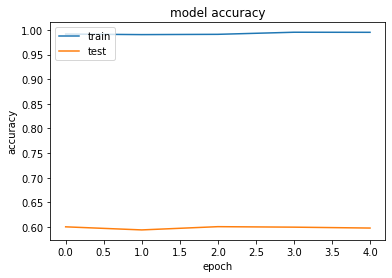

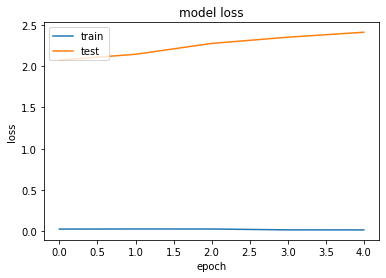

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **GRU**

In [31]:

model5 = keras.Sequential() 
model5.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen))
model5.add(layers.GRU(256))
model5.add(layers.Dense(3, activation='softmax'))
print(model5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 302, 32)           1064608   
                                                                 
 gru (GRU)                   (None, 256)               222720    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,288,099
Trainable params: 1,288,099
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
history = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
222/222 [==============================] - 8s 29ms/step - loss: 0.9656 - accuracy: 0.5246 - val_loss: 0.8557 - val_accuracy: 0.6092
Epoch 2/10
222/222 [==============================] - 6s 25ms/step - loss: 0.6193 - accuracy: 0.7470 - val_loss: 0.9721 - val_accuracy: 0.6273
Epoch 3/10
222/222 [==============================] - 6s 25ms/step - loss: 0.3138 - accuracy: 0.8844 - val_loss: 1.0706 - val_accuracy: 0.6192
Epoch 4/10
222/222 [==============================] - 6s 25ms/step - loss: 0.1584 - accuracy: 0.9448 - val_loss: 1.3558 - val_accuracy: 0.6189
Epoch 5/10
222/222 [==============================] - 6s 25ms/step - loss: 0.0952 - accuracy: 0.9695 - val_loss: 1.7033 - val_accuracy: 0.6141
Epoch 6/10
222/222 [==============================] - 6s 26ms/step - loss: 0.0603 - accuracy: 0.9797 - val_loss: 1.8876 - val_accuracy: 0.6143
Epoch 7/10
222/222 [==============================] - 6s 25ms/step - loss: 0.0535 - accuracy: 0.9829 - val_loss: 1.9649 - val_accuracy: 0.6034

In [34]:
loss, metric = model5.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.595


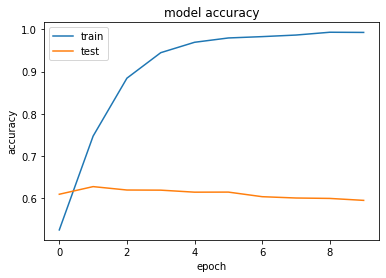

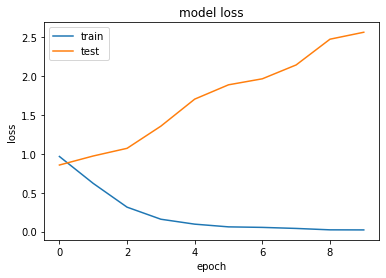

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **GRU + Dropout**

In [37]:

model6 = keras.Sequential() 
model6.add(layers.Embedding(vocab_size, 
                    32, 
                    input_length = maxlen))
model6.add(layers.GRU(256 , return_sequences=True))
model4.add(layers.Dropout(0.33))
model6.add(layers.GRU(128 , return_sequences=True))
model6.add(layers.Dropout(0.33))
model6.add(layers.GRU(64))
model6.add(layers.Dense(3, activation='softmax'))
print(model6.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 302, 32)           1064608   
                                                                 
 gru_4 (GRU)                 (None, 302, 256)          222720    
                                                                 
 gru_5 (GRU)                 (None, 302, 128)          148224    
                                                                 
 dropout_5 (Dropout)         (None, 302, 128)          0         
                                                                 
 gru_6 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,472,995
Trainable params: 1,472,995
No

In [38]:
model6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
history = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
222/222 [==============================] - 18s 59ms/step - loss: 0.9523 - accuracy: 0.5384 - val_loss: 0.8347 - val_accuracy: 0.6294
Epoch 2/10
222/222 [==============================] - 12s 56ms/step - loss: 0.5837 - accuracy: 0.7686 - val_loss: 0.8657 - val_accuracy: 0.6357
Epoch 3/10
222/222 [==============================] - 12s 55ms/step - loss: 0.2799 - accuracy: 0.8992 - val_loss: 1.0782 - val_accuracy: 0.6286
Epoch 4/10
222/222 [==============================] - 20s 89ms/step - loss: 0.1491 - accuracy: 0.9487 - val_loss: 1.3781 - val_accuracy: 0.6172
Epoch 5/10
222/222 [==============================] - 14s 65ms/step - loss: 0.0929 - accuracy: 0.9691 - val_loss: 1.5861 - val_accuracy: 0.6202
Epoch 6/10
222/222 [==============================] - 14s 62ms/step - loss: 0.0617 - accuracy: 0.9804 - val_loss: 1.8646 - val_accuracy: 0.6139
Epoch 7/10
222/222 [==============================] - 13s 57ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 2.0683 - val_accuracy:

In [40]:
loss, metric = model6.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.601


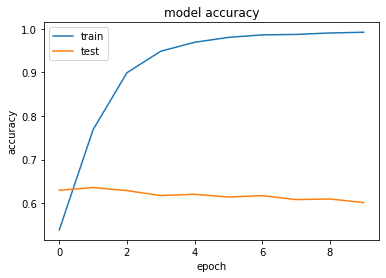

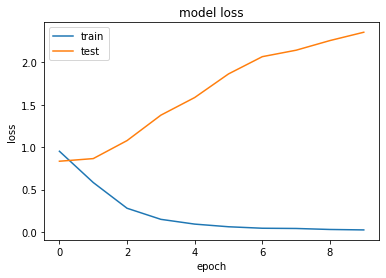

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()